In [1]:
import openmc
import math
import openmc.deplete

In [2]:
###############################################################################
#                      Simulation Input File Parameters
###############################################################################

# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 1000


In [3]:
###############################################################################
#                 Exporting to OpenMC materials.xml file
###############################################################################


# Instantiate some Materials and register the appropriate Nuclides

#UO2 fuel composition
uo2 = openmc.Material(material_id=1, name='UO2 fuel at 4.2% wt enrichment')
uo2.set_density('g/cm3', 10.55)
uo2.add_element('U', 1, enrichment=4.2)
uo2.add_element('O', 2)
uo2.temperature = 1200
uo2.deplete = True

#Helium Composition
helium = openmc.Material(material_id=2, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 1,'wo')
helium.temperature = 613

#zircaloy clad
zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014  , 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001  , 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')
zircaloy.temperature = 613

#water 
water = openmc.Material(material_id=4, name='Water Moderator')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 0.1111,'wo' )
water.add_nuclide('O16', 0.8889 ,'wo')
water.add_s_alpha_beta('c_H_in_H2O')
water.temperature= 573

# Instantiate a Materials collection and export to XML

materials_file = openmc.Materials([uo2, helium, zircaloy, water])
materials_file.export_to_xml()


In [4]:
###############################################################################
#                 Exporting to OpenMC geometry.xml file
###############################################################################

# Instantiate ZCylinder surfaces


fuel_or  = openmc.ZCylinder(surface_id=2, x0=0, y0=0, r=0.4096, name='Fuel OR')
clad_ir  = openmc.ZCylinder(surface_id=3, x0=0, y0=0, r=0.4178, name='Clad IR')
clad_or  = openmc.ZCylinder(surface_id=4, x0=0, y0=0, r=0.4750, name='Clad OR')
left     = openmc.XPlane(surface_id=5, x0=-0.6300, name='left')
right    = openmc.XPlane(surface_id=6, x0=0.6300, name='right')
bottom   = openmc.YPlane(surface_id=7, y0=-0.6300, name='bottom')
top      = openmc.YPlane(surface_id=8, y0=0.6300, name='top')

left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
top.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'

# Instantiate Cells

fuel = openmc.Cell(cell_id=2, name='Fuel')
gap = openmc.Cell(cell_id=3, name='Gap')
clad = openmc.Cell(cell_id=4, name='Cladding')
water1 = openmc.Cell(cell_id=5, name='Water')

# Use surface half-spaces to define regions

fuel.region  = -fuel_or
gap.region  = +fuel_or & -clad_ir
clad.region = +clad_ir & -clad_or
water1.region = +clad_or & +left & -right & +bottom & -top

# Register Materials with Cells

fuel.fill = uo2
gap.fill = helium
clad.fill = zircaloy
water1.fill = water

# Instantiate Universe

root = openmc.Universe(universe_id=1, name='root universe')

# Register Cells with Universe

root.add_cells([fuel, gap, clad, water1])

# Instantiate a Geometry, register the root Universe, and export to XML

geometry = openmc.Geometry(root)
geometry.export_to_xml()


In [5]:
###############################################################################
#                   Exporting to OpenMC plots.xml file
###############################################################################

plot_xy = openmc.Plot()
plot_xy.basis ='xy'
plot_xy.origin = [0, 0, 0]
plot_xy.width = [2, 2]
plot_xy.pixels = [1000, 1000]

plot_xy.colors={
water1:'blue',
fuel:'red',
clad:'black',
gap:'green'}

# Instantiate a Plots collection, add plots, and export to XML

plot_file = openmc.Plots()
plot_file.append(plot_xy)
plot_file.export_to_xml()


In [6]:
###############################################################################
#                   Exporting to OpenMC settings.xml file
###############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML

settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.temperature = {'method':'interpolation'}

# Create an initial uniform spatial source distribution over fissionable zones

bounds = [-0.6300, -0.6300, -1, 0.6300, 0.6300, 1]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

settings_file.export_to_xml()


In [7]:
###############################################################################
#                   Exporting to OpenMC tallies.xml file
###############################################################################

# Instantiate a tally mesh

mesh = openmc.RegularMesh()
mesh.dimension = [100, 100, 1]
mesh.lower_left = [-0.6300, -0.6300, -1.e50]
mesh.upper_right = [0.6300, 0.6300, 1.e50]

# Instantiate some tally Filters

energy_filter = openmc.EnergyFilter([0., 4., 20.e6])
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally

tally = openmc.Tally(tally_id=1, name='tally 1')
tally.filters = [energy_filter, mesh_filter]
tally.scores = ['flux', 'fission', 'nu-fission']

# Instantiate a Tallies collection and export to XML

tallies_file = openmc.Tallies([tally])
tallies_file.export_to_xml()


In [8]:
##################################################################################
#                   Depletion Calculation (with "MWd/Kg" unit)
##################################################################################
#volume specification
uo2.volume = 0.4423362456
#depletion chain specification
operator = openmc.deplete.Operator(geometry, settings_file,chain_file="/home/ashraful/Desktop/openmc/new/chain_casl_pwr.xml")
power = 176 # W/cm
time_steps = [5] * 12
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power,timestep_units='MWd/kg')
integrator.integrate()


In [9]:
###################################################################
#                         Find Out the Result
###################################################################

import openmc
import openmc.deplete
results = openmc.deplete.ResultsList.from_hdf5("./depletion_results.h5")

In [10]:
time, k = results.get_eigenvalue()

In [11]:
k

array([[1.36372835, 0.00306239],
       [1.24994074, 0.00274467],
       [1.18617629, 0.00295718],
       [1.1441868 , 0.00317678],
       [1.09763146, 0.00295199],
       [1.06383974, 0.00306966],
       [1.03067143, 0.00314169],
       [0.99495447, 0.00260049],
       [0.96529694, 0.00281726],
       [0.93662621, 0.00264269],
       [0.90984264, 0.00298005],
       [0.8881966 , 0.00264216],
       [0.86541821, 0.00275831]])

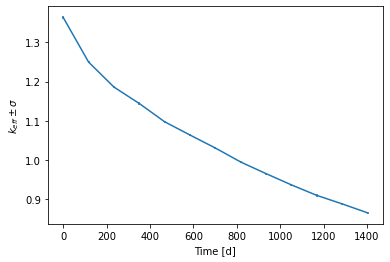

In [12]:
time /= (24 * 60 * 60)
import matplotlib.pyplot as plt
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

In [13]:
_time, u5 = results.get_atoms("1", "U235")
_time, xe135 = results.get_atoms("1", "Xe135")

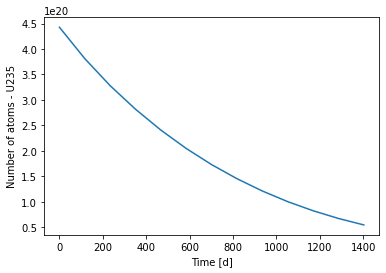

In [14]:
# U-235 cooncentration vs time
plt.plot(time, u5, label="U235")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - U235");

Text(0, 0.5, 'Xe-135 atom concentration')

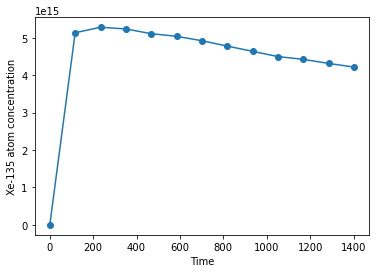

In [15]:
plt.plot(time,xe135,"-o")
plt.xlabel("Time")
plt.ylabel("Xe-135 atom concentration")